In [7]:
import re
from collections import Counter

import nltk
nltk.download('movie_reviews')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

from nltk.corpus import movie_reviews, stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.metrics import confusion_matrix, classification_report

sns.set(style="whitegrid")

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# -------------------------
# 1. Load dataset into DataFrame
# -------------------------
docs = []
for category in movie_reviews.categories():            # categories(): ['neg','pos']
    for fid in movie_reviews.fileids(category):
        text = movie_reviews.raw(fid)
        docs.append((text, category))

df = pd.DataFrame(docs, columns=['text', 'label'])
print("Dataset shape:", df.shape)
print(df['label'].value_counts())

Dataset shape: (2000, 2)
label
neg    1000
pos    1000
Name: count, dtype: int64


In [8]:
# -------------------------
# 2. Basic cleaning helper
# -------------------------
stop_words = set(stopwords.words('english'))

def clean_text_for_tokens(text):
    text = text.lower()
    # remove URLs, numbers and non-letters (keep spaces)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = nltk.word_tokenize(text, language='english') # Explicitly specify language
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    return tokens

# Example: create a cleaned "joined" text column used for WordClouds
df['clean_tokens'] = df['text'].apply(clean_text_for_tokens)
df['clean_text'] = df['clean_tokens'].apply(lambda toks: " ".join(toks))

In [9]:
# -------------------------
# 3. Lexicon-based sentiment: VADER (good for short/social texts)
# -------------------------
sia = SentimentIntensityAnalyzer()
df['vader_compound'] = df['text'].apply(lambda t: sia.polarity_scores(t)['compound'])
# map to sentiment labels using common thresholds
def vader_label(c):
    if c >= 0.05:
        return 'pos'
    elif c <= -0.05:
        return 'neg'
    else:
        return 'neu'
df['vader_sentiment'] = df['vader_compound'].apply(vader_label)

# Also compute TextBlob polarity & subjectivity (optional)
df['tb_polarity'] = df['text'].apply(lambda t: TextBlob(t).sentiment.polarity)
df['tb_subjectivity'] = df['text'].apply(lambda t: TextBlob(t).sentiment.subjectivity)
df['tb_sentiment'] = df['tb_polarity'].apply(lambda p: 'pos' if p > 0 else ('neg' if p < 0 else 'neu'))


/tmp/ipython-input-2056867478.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette='pastel')


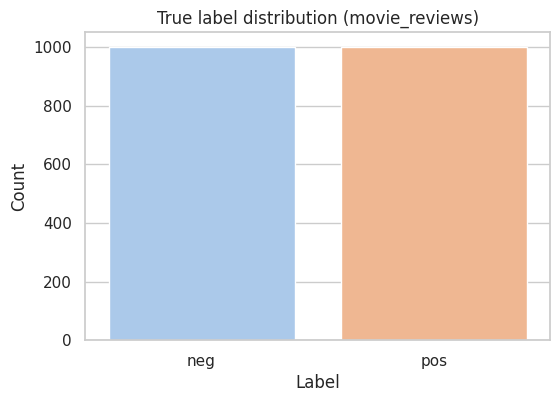

In [10]:
# -------------------------
# 4. Visualizations
# -------------------------

# 4.1 Label distribution (true labels)
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df, palette='pastel')
plt.title("True label distribution (movie_reviews)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

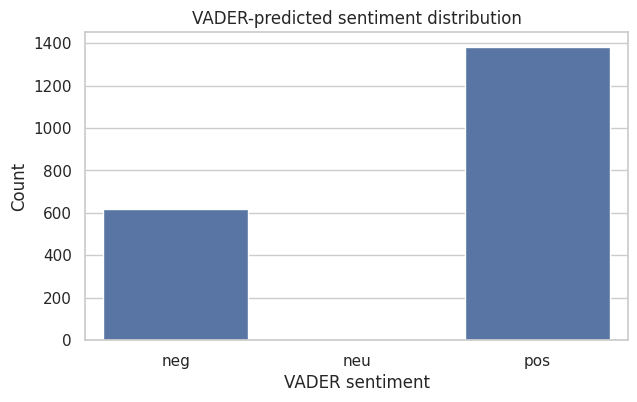

In [11]:
# 4.2 VADER sentiment distribution
plt.figure(figsize=(7,4))
sns.countplot(x='vader_sentiment', data=df, order=['neg','neu','pos'])
plt.title("VADER-predicted sentiment distribution")
plt.xlabel("VADER sentiment")
plt.ylabel("Count")
plt.show()

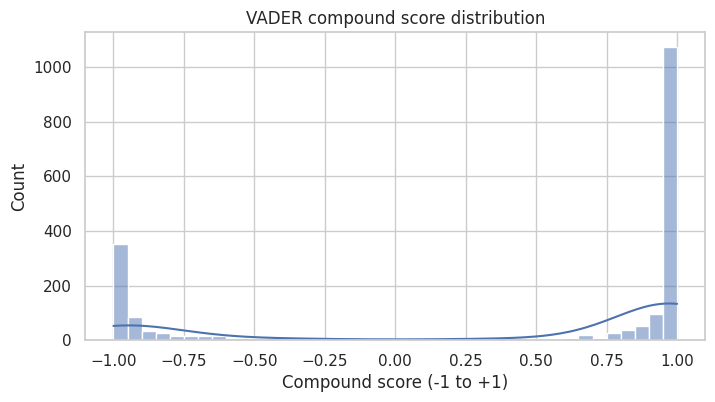

In [12]:
# 4.3 VADER compound score distribution
plt.figure(figsize=(8,4))
sns.histplot(df['vader_compound'], bins=40, kde=True)
plt.title("VADER compound score distribution")
plt.xlabel("Compound score (-1 to +1)")
plt.show()


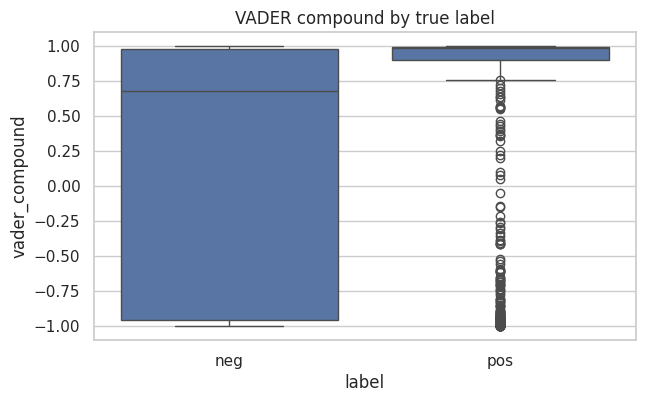

In [13]:
# 4.4 Boxplot: compound by true label
plt.figure(figsize=(7,4))
sns.boxplot(x='label', y='vader_compound', data=df)
plt.title("VADER compound by true label")
plt.show()

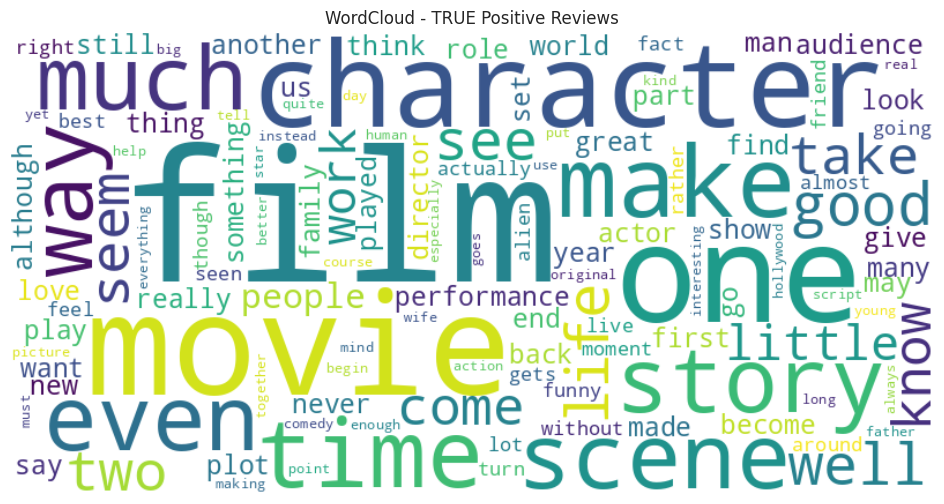

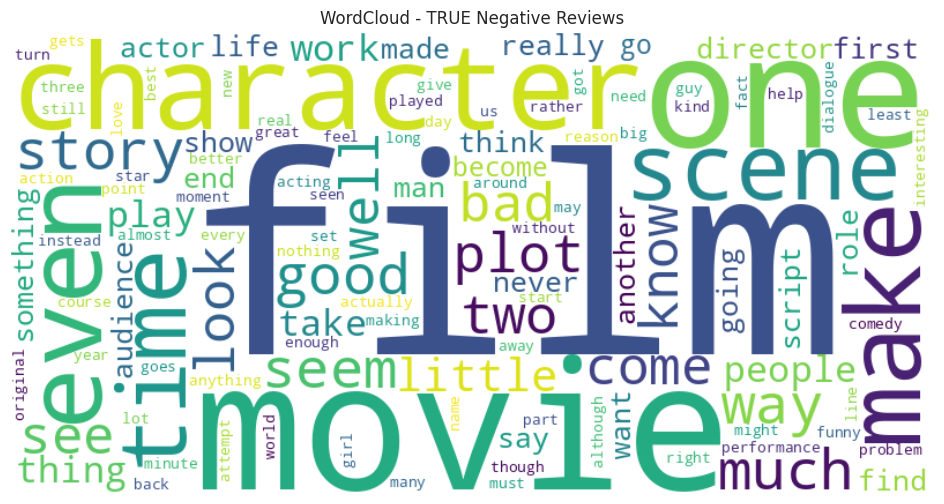

In [14]:
# 4.5 WordClouds for positive vs negative (true labels)
pos_text = " ".join(df[df['label'] == 'pos']['clean_text'].values)
neg_text = " ".join(df[df['label'] == 'neg']['clean_text'].values)

wc_pos = WordCloud(width=800, height=400, background_color='white', max_words=120).generate(pos_text)
wc_neg = WordCloud(width=800, height=400, background_color='white', max_words=120).generate(neg_text)

plt.figure(figsize=(12,6))
plt.imshow(wc_pos, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - TRUE Positive Reviews')
plt.show()

plt.figure(figsize=(12,6))
plt.imshow(wc_neg, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud - TRUE Negative Reviews')
plt.show()

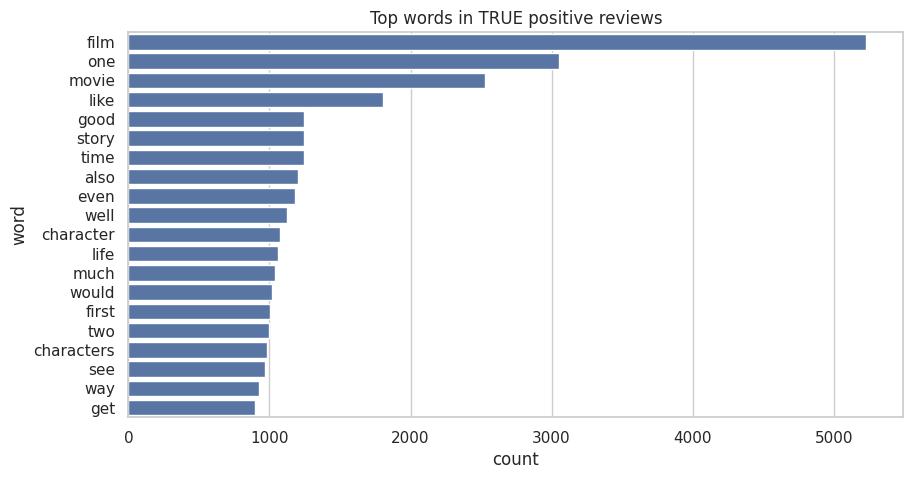

In [18]:
# 4.6 Top tokens per true label (bar plots)
def top_n_words(text_series, n=20):
    tokens = " ".join(text_series).split()
    c = Counter(tokens)
    return c.most_common(n)

top_pos = top_n_words(df[df['label']=='pos']['clean_text'], 20)
top_neg = top_n_words(df[df['label']=='neg']['clean_text'], 20)

pos_df = pd.DataFrame(top_pos, columns=['word','count'])
neg_df = pd.DataFrame(top_neg, columns=['word','count'])

plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=pos_df)
plt.title('Top words in TRUE positive reviews')
plt.show()




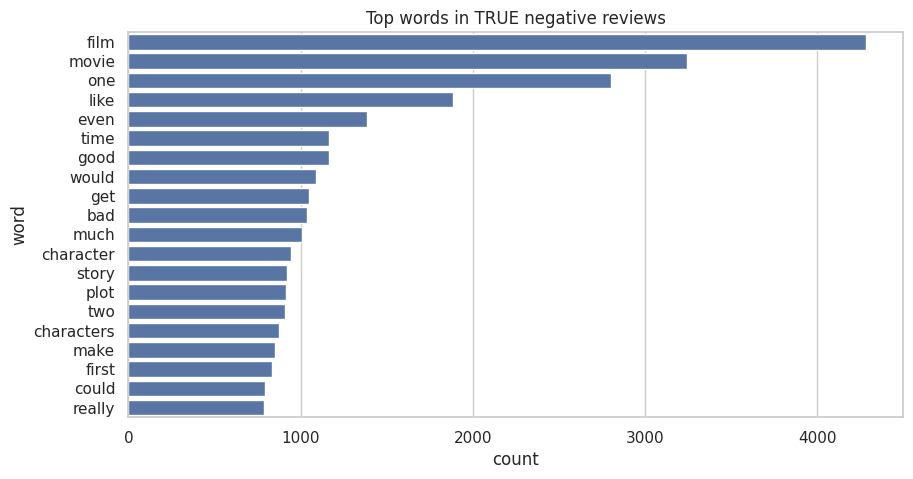

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(x='count', y='word', data=neg_df)
plt.title('Top words in TRUE negative reviews')
plt.show()

In [16]:
# -------------------------
# 5. Compare VADER predictions with true labels
# -------------------------
# Many texts will be classified as 'neu' by VADER - we filter those out to compare pos vs neg alignment,
# or you can map 'neu' to nearest class. We'll show both approaches.

# Approach A: ignore 'neu' and compare only pos/neg
df_non_neu = df[df['vader_sentiment'] != 'neu'].copy()
y_true = df_non_neu['label']
y_pred = df_non_neu['vader_sentiment']

print("\nClassification report (VADER vs true labels) [excluding 'neu']:\n")
print(classification_report(y_true, y_pred, digits=4))



Classification report (VADER vs true labels) [excluding 'neu']:

              precision    recall  f1-score   support

         neg     0.7196    0.4440    0.5492      1000
         pos     0.5977    0.8268    0.6938       999

    accuracy                         0.6353      1999
   macro avg     0.6586    0.6354    0.6215      1999
weighted avg     0.6587    0.6353    0.6215      1999



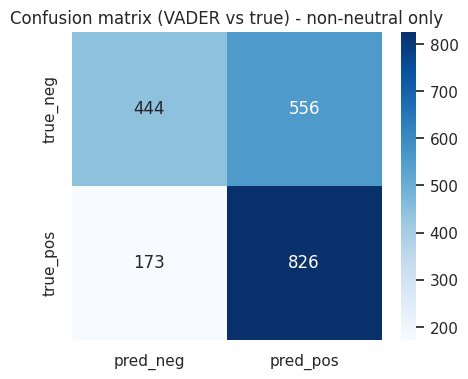

In [17]:
# Confusion matrix (non-neutral)
cm = confusion_matrix(y_true, y_pred, labels=['neg','pos'])
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['pred_neg','pred_pos'], yticklabels=['true_neg','true_pos'])
plt.title("Confusion matrix (VADER vs true) - non-neutral only")
plt.show()